<a href="https://colab.research.google.com/github/kesha001/Investigation-of-the-structure-of-sparce-neural-networks/blob/main/LenetPruning_iterative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import random

In [ ]:
def plot_kernels(tensor, num_cols=3):
    if not tensor.ndim==4:
        raise Exception("assumes a 4D tensor")
    if not tensor.shape[-1]==3:
        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5x5 image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, int(x.nelement() / x.shape[0]))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train_model(train_loader, model, num_epochs, criterion, optimizer, print_res=True):
    losses = []
    accs = []
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            outputs = model(images)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            accs.append(correct / labels.size(0))
            if (print_res):
                if ((i + 1) % 100 == 0):
                    print('epoch: {}/{}, step: {}/{}, loss: {:.6f}, accuracy: {:.3f}%'
                          .format(epoch + 1, num_epochs, i + 1, len(train_loader), loss.item(), (correct / labels.size(0)) * 100))

    return losses, accs

def test_model(test_loader, model, print_acc=True):
    ims = []
    lbls = []
    outs = []
    out_pr = []
    out_act = []
    correct = 0
    total = 0
    lab_i = 0
    model.eval()
    for images, labels in test_loader:
        outputs = model(images)
        
        for i in range(labels.size(0)):
            outs.append(outputs[i])
            ims.append(images[i])
            lbls.append(labels[i])
        max_val, predicted = torch.max(outputs.data, 1)

        for i in range(labels.size(0)):
            out_pr.append(max_val[i])
            out_act.append(outputs[i][labels[i]])

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    if print_acc:
      print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))
    accuracy = correct / total
    
    return accuracy

def flatten(t):
    t = t.reshape(1, -1)
    t = t.squeeze()
    return t

def one_shot_lenet_prune(model_inp, percent):
    model = LeNet()

    model.load_state_dict(model_inp.state_dict())
    parameters_to_prune = (
    (model.conv1, 'weight'),
    (model.conv2, 'weight'),
    (model.fc1, 'weight'),
    (model.fc2, 'weight'),
    (model.fc3, 'weight'),
    )

    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=percent,
    )

    return model

def lenet_print_sparcity(model, print_spar=True):
  if print_spar:  
    print(
      "Sparsity in conv1.weight: {:.2f}%".format(
          100. * float(torch.sum(model.conv1.weight == 0))
          / float(model.conv1.weight.nelement())
      )
    )
    print(
        "Sparsity in conv2.weight: {:.2f}%".format(
            100. * float(torch.sum(model.conv2.weight == 0))
            / float(model.conv2.weight.nelement())
        )
    )
    print(
        "Sparsity in fc1.weight: {:.2f}%".format(
            100. * float(torch.sum(model.fc1.weight == 0))
            / float(model.fc1.weight.nelement())
        )
    )
    print(
        "Sparsity in fc2.weight: {:.2f}%".format(
            100. * float(torch.sum(model.fc2.weight == 0))
            / float(model.fc2.weight.nelement())
        )
    )
    print(
        "Sparsity in fc3.weight: {:.2f}%".format(
            100. * float(torch.sum(model.fc3.weight == 0))
            / float(model.fc3.weight.nelement())
        )
    )


  glob_sparc = 100. * float(
              torch.sum(model.conv1.weight == 0)
              + torch.sum(model.conv2.weight == 0)
              + torch.sum(model.fc1.weight == 0)
              + torch.sum(model.fc2.weight == 0)
              + torch.sum(model.fc3.weight == 0)
          ) / float(
              model.conv1.weight.nelement()
              + model.conv2.weight.nelement()
              + model.fc1.weight.nelement()
              + model.fc2.weight.nelement()
              + model.fc3.weight.nelement()
          )
  if print_spar:
    print(
        "Global sparsity: {:.2f}%".format(glob_sparc)
    )

  return glob_sparc

def save_model(model, model_dir, model_filename):

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model_filepath = os.path.join(model_dir, model_filename)
    torch.save(model.state_dict(), model_filepath)


def load_model(model, model_filepath, device):

    model.load_state_dict(torch.load(model_filepath, map_location=device))

    return model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
num_epochs = 5 
batch_size = 100 
learning_rate = 0.001
DATA_PATH = 'mnist_data'

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) 

train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True) 
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size) 
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



In [ ]:
import torch.nn.functional as F

In [ ]:
untr_model = LeNet().to(device=device)
loss_func = nn.CrossEntropyLoss()
model = LeNet().to(device=device)

model.load_state_dict(untr_model.state_dict())
optim_func = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
[i for i in untr_model.children()]

[Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1)),
 Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1)),
 Linear(in_features=400, out_features=120, bias=True),
 Linear(in_features=120, out_features=84, bias=True),
 Linear(in_features=84, out_features=10, bias=True)]

In [ ]:
indx = 0
untr_modules = [i for i in untr_model.children()]
untr_1l = untr_modules[indx].weight.data
print(untr_1l)
modules = [i for i in model.children()]
model_1l = modules[indx].weight.data
print()
print(model_1l)

tensor([[[[-0.2278,  0.1082, -0.1457],
          [ 0.2985,  0.0842,  0.2832],
          [-0.0099, -0.2160,  0.0171]]],


        [[[ 0.1006, -0.0013,  0.0224],
          [ 0.0139,  0.2418,  0.0692],
          [ 0.2875, -0.3222, -0.0575]]],


        [[[ 0.1977,  0.2614,  0.3025],
          [ 0.0143, -0.0192,  0.2037],
          [-0.1865,  0.1827,  0.0470]]],


        [[[-0.2610, -0.0315, -0.0694],
          [ 0.2503, -0.1998,  0.1033],
          [ 0.0009, -0.1235,  0.1955]]],


        [[[ 0.0941, -0.1110,  0.2243],
          [-0.2815,  0.2021, -0.2196],
          [-0.2915, -0.0789, -0.0725]]],


        [[[ 0.2891, -0.2912, -0.2723],
          [-0.2097, -0.0413, -0.1777],
          [ 0.1545, -0.1236,  0.2222]]]])

tensor([[[[-0.2278,  0.1082, -0.1457],
          [ 0.2985,  0.0842,  0.2832],
          [-0.0099, -0.2160,  0.0171]]],


        [[[ 0.1006, -0.0013,  0.0224],
          [ 0.0139,  0.2418,  0.0692],
          [ 0.2875, -0.3222, -0.0575]]],


        [[[ 0.1977,  0.2614,  0.

In [ ]:
untr_1l_distr = F.log_softmax(flatten(untr_1l), -1)
print(untr_1l_distr)
print()
model_1l_distr = F.softmax(flatten(model_1l), -1)
print(model_1l_distr)
torch.nn.KLDivLoss(reduction="sum")(untr_1l_distr, model_1l_distr)

tensor([-4.2419, -3.9059, -4.1598, -3.7156, -3.9299, -3.7309, -4.0240, -4.2301,
        -3.9970, -3.9135, -4.0154, -3.9917, -4.0002, -3.7723, -3.9449, -3.7266,
        -4.3363, -4.0716, -3.8164, -3.7527, -3.7117, -3.9998, -4.0333, -3.8104,
        -4.2006, -3.8314, -3.9671, -4.2751, -4.0456, -4.0835, -3.7638, -4.2139,
        -3.9108, -4.0132, -4.1376, -3.8186, -3.9200, -4.1251, -3.7898, -4.2956,
        -3.8120, -4.2337, -4.3056, -4.0930, -4.0866, -3.7250, -4.3053, -4.2864,
        -4.2238, -4.0554, -4.1918, -3.8597, -4.1377, -3.7919])

tensor([0.0144, 0.0201, 0.0156, 0.0243, 0.0196, 0.0240, 0.0179, 0.0146, 0.0184,
        0.0200, 0.0180, 0.0185, 0.0183, 0.0230, 0.0194, 0.0241, 0.0131, 0.0170,
        0.0220, 0.0235, 0.0244, 0.0183, 0.0177, 0.0221, 0.0150, 0.0217, 0.0189,
        0.0139, 0.0175, 0.0168, 0.0232, 0.0148, 0.0200, 0.0181, 0.0160, 0.0220,
        0.0198, 0.0162, 0.0226, 0.0136, 0.0221, 0.0145, 0.0135, 0.0167, 0.0168,
        0.0241, 0.0135, 0.0138, 0.0146, 0.0173, 0.0151, 

tensor(-5.1688e-09)

In [ ]:
lenet_print_sparcity(model, print_spar=False)

0.0

In [ ]:
num_epochs = 5 
batch_size = 100 
learning_rate = 0.001
DATA_PATH = 'mnist_data'
perc = 0.3

In [ ]:
model_it = LeNet().to(device)
loss_func = nn.CrossEntropyLoss()
optim_func = torch.optim.Adam(model_it.parameters(), lr=learning_rate)

untr_model = LeNet().to(device)
untr_model.load_state_dict(model_it.state_dict())


# distances non trained vs trained
results_bp = dict()
# distances non trained vs pruned+trained
results_ap = dict()
for name, module in untr_model.named_modules():
    if name:
        results_bp[name] = None
        results_ap[name] = []

untr_modules = [i for i in untr_model.children()]
modules = [i for i in model_it.children()]


for indx in range(len(untr_modules)):
        
    untr_1l = untr_modules[indx].weight.data
    untr_1l_distr = F.log_softmax(flatten(untr_1l), -1)
    
    model_1l = modules[indx].weight.data
    model_1l_distr = F.softmax(flatten(model_1l), -1)

    print(list(untr_model.named_modules())[indx+1][0],torch.nn.KLDivLoss(reduction="sum")(untr_1l_distr, model_1l_distr))

    results_bp[list(untr_model.named_modules())[indx+1][0]] = torch.nn.KLDivLoss(reduction="sum")(untr_1l_distr, model_1l_distr).item()

conv1 tensor(1.2610e-07)
conv2 tensor(-1.2346e-07)
fc1 tensor(2.5747e-07)
fc2 tensor(-3.3785e-07)
fc3 tensor(2.0019e-07)


In [ ]:
print("Model training for hyperparamethers batch size = {}, learning rate alpha = {}".format(batch_size, learning_rate))
loss_list, acc_list = train_model(train_loader, model_it, num_epochs, loss_func, optim_func, print_res=False)

iterative_accs_bft = dict()
iterative_accs_aft = dict()

accuracy = test_model(test_loader, model_it)
sparcity = lenet_print_sparcity(model_it, print_spar=True)
iterative_accs_bft[sparcity] = accuracy

iterative_accs = dict()
for i in range(10):
    parameters_to_prune = (
        (model_it.conv1, 'weight'),
        (model_it.conv2, 'weight'),
        (model_it.fc1, 'weight'),
        (model_it.fc2, 'weight'),
        (model_it.fc3, 'weight'),
    )
    # parameters_to_prune_conv = (
    #     (model_it.conv1, 'weight'),
    #     (model_it.conv2, 'weight'),
    #     )
    # parameters_to_prune_func = (
    #     (model_it.fc1, 'weight'),
    #     (model_it.fc2, 'weight'),
    #     (model_it.fc3, 'weight'),
    #  )
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=perc,
    )
    accuracy = test_model(test_loader, model_it)
    lenet_print_sparcity(model_it, print_spar=True)
    iterative_accs_bft[sparcity] = accuracy
    
    it_modules = [i for i in model_it.children()]
    for indx in range(len(untr_modules)):

        untr_1l = untr_modules[indx].weight.data
        untr_1l_distr = F.log_softmax(flatten(untr_1l), -1)

        it_model_1l = it_modules[indx].weight.data
        it_model_1l_distr = F.softmax(flatten(it_model_1l), -1)

        # print(torch.nn.KLDivLoss(reduction="sum")(untr_1l_distr, it_model_1l_distr).item())

        results_ap[list(untr_model.named_modules())[indx+1][0]].append(torch.nn.KLDivLoss(reduction="sum")(untr_1l_distr, it_model_1l_distr).item())


    print("Fine-tuning...")

    print("Model training for hyperparamethers batch size = {}, learning rate alpha = {}".format(batch_size, learning_rate))
    loss_list, acc_list = train_model(train_loader, model_it, num_epochs, loss_func, optim_func, print_res=False)
    accuracy_ft = test_model(test_loader, model_it)

    sparcity_ft = lenet_print_sparcity(model_it, print_spar=True)

    iterative_accs_aft[sparcity_ft] = accuracy_ft

    model_filename_prefix="pruned_model"
    model_dir="saved_models"

    model_filename = "{}_{}".format(model_filename_prefix, i + 1)
    model_filepath = os.path.join(model_dir, model_filename)

    save_model(model_it, model_dir, model_filename)
    model_it = load_model(model_it, model_filepath, device)

    iterative_accs[sparcity_ft] = []
    iterative_accs[sparcity_ft].append(accuracy)

    it_modules = [i for i in model_it.children()]
    for indx in range(len(untr_modules)):

        untr_1l = untr_modules[indx].weight.data
        untr_1l_distr = F.log_softmax(flatten(untr_1l), -1)

        it_model_1l = it_modules[indx].weight.data
        it_model_1l_distr = F.softmax(flatten(it_model_1l), -1)

        # print(torch.nn.KLDivLoss(reduction="sum")(untr_1l_distr, it_model_1l_distr).item())

        results_ap[list(untr_model.named_modules())[indx+1][0]].append(torch.nn.KLDivLoss(reduction="sum")(untr_1l_distr, it_model_1l_distr).item())

    results_ap_df = pd.DataFrame.from_dict(results_ap)
    results_ap_df.to_csv(f'lenet_mnist_results_ap_df_{i}.csv')
    print(f'resutls_ap_{i}: ',results_ap)
    print(f'iterative_accs_bft_{i}: ',iterative_accs_bft)
    print(f'iterative_accs_aft_{i}: ',iterative_accs_aft)
    print(f'iterative_accs_{i}: ',iterative_accs)
    print(f'resutls_bp_{i}: ',results_bp)


Model training for hyperparamethers batch size = 100, learning rate alpha = 0.001
Test Accuracy of the model on the 10000 test images: 98.59 %
Sparsity in conv1.weight: 0.00%
Sparsity in conv2.weight: 0.00%
Sparsity in fc1.weight: 0.00%
Sparsity in fc2.weight: 0.00%
Sparsity in fc3.weight: 0.00%
Global sparsity: 0.00%
Test Accuracy of the model on the 10000 test images: 98.57000000000001 %
Sparsity in conv1.weight: 3.70%
Sparsity in conv2.weight: 12.62%
Sparsity in fc1.weight: 32.35%
Sparsity in fc2.weight: 21.82%
Sparsity in fc3.weight: 13.57%
Global sparsity: 30.00%
Fine-tuning...
Model training for hyperparamethers batch size = 100, learning rate alpha = 0.001
Test Accuracy of the model on the 10000 test images: 98.7 %
Sparsity in conv1.weight: 3.70%
Sparsity in conv2.weight: 12.62%
Sparsity in fc1.weight: 32.35%
Sparsity in fc2.weight: 21.82%
Sparsity in fc3.weight: 13.57%
Global sparsity: 30.00%
resutls_ap_0:  {'conv1': [0.014520242810249329, 0.021731602028012276], 'conv2': [0.006

In [ ]:
results_ap_df = pd.DataFrame.from_dict(results_ap)
results_ap_df.to_csv('results_ap_df.csv')

In [ ]:
iterative_accs_bft

{0.0: 0.8828}

In [ ]:
iterative_accs_aft

{29.999331528460175: 0.987,
 50.99936495203717: 0.9877,
 65.69905411277115: 0.9884,
 75.99017346836459: 0.9895,
 83.19295430997025: 0.9876,
 88.23490089909423: 0.9875,
 91.76443062936596: 0.9869,
 94.23443296901634: 0.9872,
 95.96410307831144: 0.9839,
 97.17403656539322: 0.9845}

In [ ]:
iterative_accs

{29.999331528460175: [0.9857],
 50.99936495203717: [0.9855],
 65.69905411277115: [0.985],
 75.99017346836459: [0.9732],
 83.19295430997025: [0.9624],
 88.23490089909423: [0.9418],
 91.76443062936596: [0.9205],
 94.23443296901634: [0.9295],
 95.96410307831144: [0.7615],
 97.17403656539322: [0.8828]}

In [ ]:
results_bp

{'conv1': 1.2610469468654628e-07,
 'conv2': -1.2345714139883057e-07,
 'fc1': 2.5747195309122617e-07,
 'fc2': -3.3785028108468396e-07,
 'fc3': 2.0019388102809899e-07}

In [ ]:
results_ap

{'conv1': [0.014520242810249329,
  0.021731602028012276,
  0.02178838849067688,
  0.028156379237771034,
  0.028242867439985275,
  0.03372674807906151,
  0.03358001261949539,
  0.04002032428979874,
  0.040963005274534225,
  0.048695579171180725,
  0.04787135496735573,
  0.05709967762231827,
  0.05720959231257439,
  0.0672386959195137,
  0.06799940019845963,
  0.0798938199877739,
  0.07695223391056061,
  0.09204967319965363,
  0.09259925782680511,
  0.10468828678131104],
 'conv2': [0.006623297464102507,
  0.009187930263578892,
  0.009229331277310848,
  0.011379564180970192,
  0.011415067128837109,
  0.013166315853595734,
  0.01313813030719757,
  0.014651775360107422,
  0.01440126821398735,
  0.016067447140812874,
  0.01566392183303833,
  0.018003029748797417,
  0.017201373353600502,
  0.019057622179389,
  0.018228480592370033,
  0.019970519468188286,
  0.01852610893547535,
  0.020126746967434883,
  0.018907105550169945,
  0.02074310928583145],
 'fc1': [0.0016766437329351902,
  0.00287138

In [ ]:
iter_prune_per, iter_acc = list(iterative_accs.keys()), []
for val in iterative_accs.values():
  iter_acc.append(sum(val)/5)

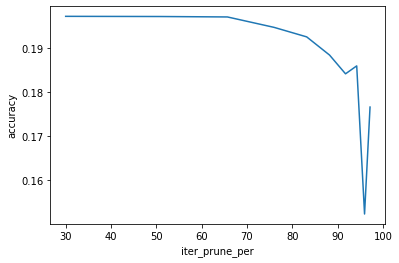

In [ ]:
iter_accs_df = pd.DataFrame({'iter_prune_per': iter_prune_per, 'accuracy': iter_acc})
fig = plt.figure()
plt.xlabel('iter_prune_per')
plt.ylabel('accuracy')
plt.plot(iter_accs_df['iter_prune_per'], iter_accs_df['accuracy'])

In [ ]:
iterative_accs_bft

{0.0: 0.8828}

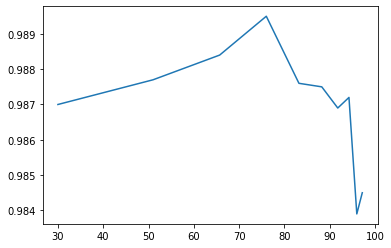

In [ ]:
x = list(iterative_accs_aft.keys())
y = list(iterative_accs_aft.values())
plt.plot(x,y)